# Avoiding Overfitting in Image Classification

_By: Harsh Kumar, Gojek_  
_13th July 20204_  

Reference: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

## Import libraries

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


## Get training and validation data

We will be using CIFAR10 dataset which has images of 10 categories

In [3]:
batch_size = 4

Define transformations of input images  
- Convert data to tensors  
- Normalize values

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

NOTE: Shuffle has been turned off for training dataset as well.  
In this notebook, we want to use the same subset of images to train the model in every epoch, so that overfitting is clearly detectable

In [5]:
trainset = torchvision.datasets.CIFAR10(root='./data',
                                        train=True,
                                        download=True,
                                        transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=2)

Files already downloaded and verified


In [6]:
valset = torchvision.datasets.CIFAR10(root='./data',
                                      train=False,
                                      download=True,
                                      transform=transform)

valloader = torch.utils.data.DataLoader(valset,
                                        batch_size=batch_size,
                                        shuffle=False,
                                        num_workers=2)

Files already downloaded and verified


Name the classes which are part of the data

In [7]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse',
           'ship', 'truck')

### Display sample images

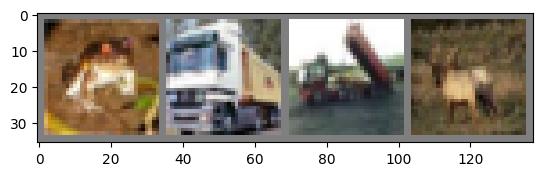

frog  truck truck deer 


In [8]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## Define model structure

In [9]:
class ImgClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [10]:
model = ImgClassificationModel()
model.to(device)

ImgClassificationModel(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

## Train the Model

Define Optimizer and Loss Function

In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

NOTE: Since shuffle is turned off, we will get images in the same sequence from trainloader. We will restrict the number of training images to first 8000 (2000 batches of 4 images each). This will allow us to clearly show overfitting

In [12]:
n_epochs = 20
train_batch_count = 2000

In [13]:
def train_model_batches(
    model: ImgClassificationModel,
    trainloader: torch.utils.data.DataLoader,
    batch_count: int
) -> (ImgClassificationModel, float):
    """
    Returns trained model for a fixed number of batches along with the training loss 
    """
    train_loss_cumm = 0.0
    for i, data_train in enumerate(trainloader, 0):
        # Start training
        model.train()
        
        # get the inputs; data is a list of [inputs, labels]
        inputs_train, labels_train = data_train[0].to(device), data_train[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        labels_train_pred = model(inputs_train)
        loss = loss_fn(labels_train_pred, labels_train)
        loss.backward()
        optimizer.step()

        train_loss_cumm += loss.item()

        # stop training after batch count if reached
        if i == batch_count:    
            break

    # Loss value is calculated per batch
    return model, train_loss_cumm / batch_count

In [14]:
def get_val_loss(model: ImgClassificationModel, valloader: torch.utils.data.DataLoader) -> float:
    """
    Returns loss value on validation dataset for the given model
    """
    loss_val_total = 0
    
    # Since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for i, data_val in enumerate(valloader, 0):
            inputs_val, labels_val = data_val[0].to(device), data_val[1].to(device)
            
            # Calculate predicted labels by running images through the network
            labels_pred_val = model(inputs_val)
            loss_val = loss_fn(labels_pred_val, labels_val)
            loss_val_total += loss_val.item()

    val_batch_count = i

    # Loss value is calculated per batch
    return loss_val_total / val_batch_count

In [15]:
train_loss_list=[]
val_loss_list=[]

# Loop over the dataset multiple times
for epoch in range(n_epochs):  

    model, train_loss = train_model_batches(model, trainloader, train_batch_count)

    # Calculate loss over validation data
    val_loss = get_val_loss(model, valloader)
    
    # Save value of loss in a list to evaluate loss values later
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    
    print(f'[{epoch + 1}] loss: {train_loss:.3f} val_loss: {val_loss:.3f}')

print('Finished Training')

[1] loss: 2.229 val_loss: 2.033
[2] loss: 1.851 val_loss: 1.694
[3] loss: 1.664 val_loss: 1.589
[4] loss: 1.552 val_loss: 1.522
[5] loss: 1.458 val_loss: 1.490
[6] loss: 1.373 val_loss: 1.478
[7] loss: 1.291 val_loss: 1.471
[8] loss: 1.207 val_loss: 1.500
[9] loss: 1.123 val_loss: 1.564
[10] loss: 1.032 val_loss: 1.634
[11] loss: 0.948 val_loss: 1.745
[12] loss: 0.862 val_loss: 1.884
[13] loss: 0.787 val_loss: 2.109
[14] loss: 0.747 val_loss: 2.208
[15] loss: 0.688 val_loss: 2.325
[16] loss: 0.657 val_loss: 2.378
[17] loss: 0.614 val_loss: 2.618
[18] loss: 0.600 val_loss: 2.541
[19] loss: 0.524 val_loss: 2.570
[20] loss: 0.494 val_loss: 3.021
Finished Training


### Plot Loss

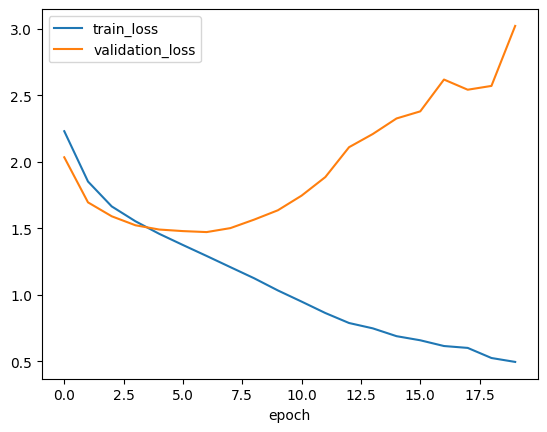

In [17]:
def plot_loss(train_loss_list, val_loss_list):
    df_loss = pd.DataFrame({"train_loss":train_loss_list, "validation_loss":val_loss_list})
    df_loss["epoch"] = df_loss.index
    
    axs = plt.subplot()
    df_loss.plot(x="epoch", y="train_loss", ax=axs)
    df_loss.plot(x="epoch", y="validation_loss", ax=axs)

plot_loss(train_loss_list, val_loss_list)

### Accuracy on Validation Data

In [18]:
def get_accuracy_val_data(model: ImgClassificationModel, valloader: torch.utils.data.DataLoader) -> float:
    correct = 0
    total = 0
    # Since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data_val in valloader:
            images, labels = data_val[0].to(device), data_val[1].to(device)
            # calculate outputs by running images through the network
            labels_pred = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(labels_pred.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

val_accuracy = get_accuracy_val_data(model, valloader)

print(f'Accuracy on the val images: {100 * val_accuracy:.2f} %')

Accuracy on the val images: 42.55 %


## Early Stopping

Re-iniatialize model

In [19]:
model = ImgClassificationModel()
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [20]:
# Path to store the model
MODEL_PATH = './cifar_model.pth'

Train the model

In [21]:
train_loss_list=[]
val_loss_list=[]

# loop over the dataset multiple times
for epoch in range(n_epochs):  

    model, train_loss = train_model_batches(model, trainloader, train_batch_count)

    # Calculate loss over validation data
    val_loss = get_val_loss(model, valloader)
    
    # Save value of loss in a list to evaluate loss values later
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    
    print(f'[{epoch + 1}] loss: {train_loss:.3f} val_loss: {val_loss:.3f}', end=" ")

    # Early Stopping Criteria
    # No need to check early checking criteria till we have atleast 3 epochs
    if len(val_loss_list)<3:
        print("-> Nothing to do")
    elif val_loss_list[-1] < val_loss_list[-2]:
        # Save the model if there is a reduction in loss on val data
        torch.save(model.state_dict(), MODEL_PATH)
        print("-> Saved Model")
    elif (val_loss_list[-1] >= val_loss_list[-2]) and (val_loss_list[-2] >= val_loss_list[-3]):
        print("-> Early Stopping")
        break
    else:
        print("-> Nothing to do")

print('Finished Training')

[1] loss: 2.196 val_loss: 1.955 -> Nothing to do
[2] loss: 1.823 val_loss: 1.701 -> Nothing to do
[3] loss: 1.647 val_loss: 1.597 -> Saved Model
[4] loss: 1.533 val_loss: 1.531 -> Saved Model
[5] loss: 1.441 val_loss: 1.484 -> Saved Model
[6] loss: 1.356 val_loss: 1.462 -> Saved Model
[7] loss: 1.279 val_loss: 1.446 -> Saved Model
[8] loss: 1.195 val_loss: 1.459 -> Nothing to do
[9] loss: 1.109 val_loss: 1.498 -> Early Stopping
Finished Training


### Plot Loss

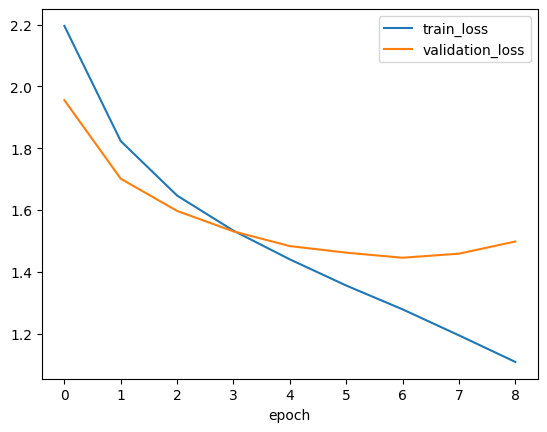

In [22]:
plot_loss(train_loss_list, val_loss_list)

### Accuracy on Validation Data

In [23]:
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [24]:
val_accuracy = get_accuracy_val_data(model, valloader)

print(f'Accuracy on the val images: {100 * val_accuracy:.2f} %')

Accuracy on the val images: 48.53 %


## Dropout

Define model with Dropout

In [40]:
class ModelDropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.1)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(120, 84)
        self.dropout = nn.Dropout(0.2)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [41]:
model = ModelDropout()
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Train the model

In [42]:
train_loss_list=[]
val_loss_list=[]

# loop over the dataset multiple times
for epoch in range(n_epochs):  

    model, train_loss = train_model_batches(model, trainloader, train_batch_count)

    # Calculate loss over validation data
    val_loss = get_val_loss(model, valloader)
    
    # Save value of loss in a list to evaluate loss values later
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    
    print(f'[{epoch + 1}] loss: {train_loss:.3f} val_loss: {val_loss:.3f}')

print('Finished Training')

[1] loss: 2.232 val_loss: 2.028
[2] loss: 1.932 val_loss: 1.820
[3] loss: 1.799 val_loss: 1.760
[4] loss: 1.701 val_loss: 1.674
[5] loss: 1.624 val_loss: 1.624
[6] loss: 1.581 val_loss: 1.595
[7] loss: 1.545 val_loss: 1.586
[8] loss: 1.509 val_loss: 1.582
[9] loss: 1.472 val_loss: 1.570
[10] loss: 1.445 val_loss: 1.558
[11] loss: 1.424 val_loss: 1.595
[12] loss: 1.402 val_loss: 1.541
[13] loss: 1.364 val_loss: 1.531
[14] loss: 1.355 val_loss: 1.517
[15] loss: 1.341 val_loss: 1.572
[16] loss: 1.324 val_loss: 1.547
[17] loss: 1.291 val_loss: 1.530
[18] loss: 1.282 val_loss: 1.511
[19] loss: 1.261 val_loss: 1.540
[20] loss: 1.253 val_loss: 1.529
Finished Training


### Plot Loss

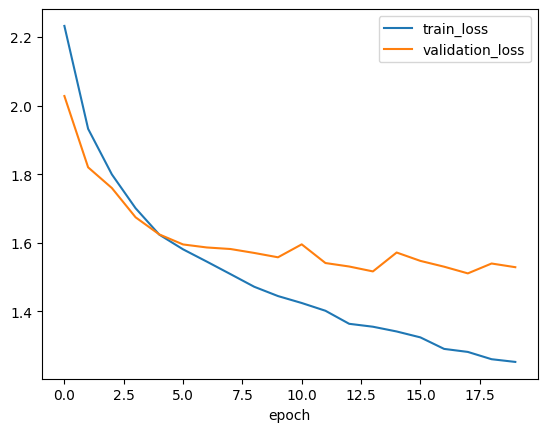

In [43]:
plot_loss(train_loss_list, val_loss_list)

### Accuracy on Validation Data

In [44]:
val_accuracy = get_accuracy_val_data(model, valloader)

print(f'Accuracy on the val images: {100 * val_accuracy:.2f} %')

Accuracy on the val images: 46.57 %


## Batch Normalization

Define model with Dropout

In [55]:
class ModelBatchNorm(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.bn1 = nn.BatchNorm2d(6)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.bn2 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.bn3 = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, 84)
        self.bn4 = nn.BatchNorm1d(84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(self.bn1(F.relu(self.conv1(x))))
        x = self.pool(self.bn2(F.relu(self.conv2(x))))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.bn3(F.relu(self.fc1(x)))
        x = self.bn4(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [56]:
model = ModelBatchNorm()
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Train the model

In [57]:
train_loss_list=[]
val_loss_list=[]

# loop over the dataset multiple times
for epoch in range(n_epochs):  

    model, train_loss = train_model_batches(model, trainloader, train_batch_count)

    # Calculate loss over validation data
    val_loss = get_val_loss(model, valloader)
    
    # Save value of loss in a list to evaluate loss values later
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    
    print(f'[{epoch + 1}] loss: {train_loss:.3f} val_loss: {val_loss:.3f}')

print('Finished Training')

[1] loss: 2.159 val_loss: 2.145
[2] loss: 2.073 val_loss: 2.075
[3] loss: 2.009 val_loss: 1.995
[4] loss: 1.954 val_loss: 1.977
[5] loss: 1.924 val_loss: 1.945
[6] loss: 1.995 val_loss: 1.981
[7] loss: 1.943 val_loss: 1.936
[8] loss: 1.900 val_loss: 1.948
[9] loss: 1.876 val_loss: 1.876
[10] loss: 1.792 val_loss: 1.864
[11] loss: 1.750 val_loss: 1.854
[12] loss: 1.708 val_loss: 1.864
[13] loss: 1.678 val_loss: 1.848
[14] loss: 1.634 val_loss: 1.851
[15] loss: 1.588 val_loss: 1.867
[16] loss: 1.562 val_loss: 1.882
[17] loss: 1.508 val_loss: 1.889
[18] loss: 1.487 val_loss: 1.904
[19] loss: 1.445 val_loss: 1.929
[20] loss: 1.382 val_loss: 1.958
Finished Training


### Plot Loss

**NOTE: The gain from batch normalization seems to be low, probably due to very small batch size (4).  
Small batch sizes can result in inaccurate estimation of mean and standard deviation**

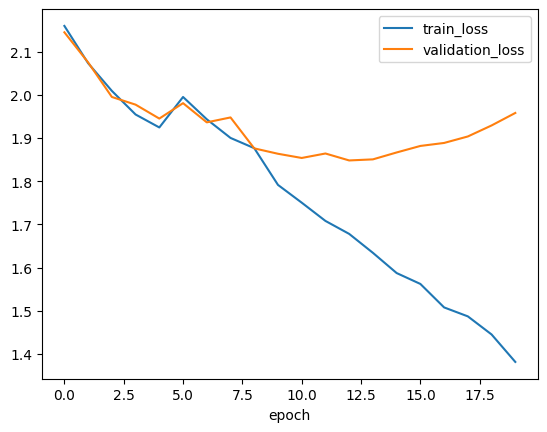

In [58]:
plot_loss(train_loss_list, val_loss_list)

### Accuracy on Validation Data

In [59]:
val_accuracy = get_accuracy_val_data(model, valloader)

print(f'Accuracy on the val images: {100 * val_accuracy:.2f} %')

Accuracy on the val images: 34.42 %
